## Guitar classifier

Objective: build a deployable model trained to distinguish 4 classic electric guitar models.

In [4]:
import fastbook
import fastai.vision.widgets
import os
from dotenv import load_dotenv
from pathlib import Path

Place a .env file at the root of the repo containing an AZURE_SEARCH_KEY env variable.

It should contain the key to an __[Azure Bing Search API](https://portal.azure.com/#create/microsoft.bingsearch)__ key (free-tier available).

In [5]:
%%capture
notebook_path = Path(os.path.abspath(''))
repo_root = notebook_path.parent.parent
load_dotenv(repo_root / '.env')

Grab images from bing for each guitar model

In [6]:
guitar_models = {'fender stratocaster': None,
                 'fender telecaster': None,
                 'gibson les paul': None,
                 'gibson sg guitar': None}
fastbook.search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

Pull down images into folders split by guitar model...

In [7]:
data_path = notebook_path / 'data'
data_path.mkdir(exist_ok=True)
for guit_key in guitar_models:
    images_path = data_path / guit_key
    images_path.mkdir(exist_ok=True)
    results = fastbook.search_images_bing(os.environ.get('AZURE_SEARCH_KEY'), guit_key)
    fastbook.download_images(images_path, urls=results.attrgot('contentUrl'))
    guitar_models[guit_key] = images_path

Clean up corrupt images, delete them, and count what's left...

In [8]:
for path in guitar_models.values():
    images = fastbook.get_image_files(path)
    corrupted = fastbook.verify_images(images)
    corrupted.map(Path.unlink)
    print(len(fastbook.get_image_files(path)))

146
144
147
146


Using data augmentation to "mix-up" the data, giving the model more to train on with a limited dataset.

/home/tom/.cache/pypoetry/virtualenvs/fastai-coursework-0G3zp8jV-py3.10/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


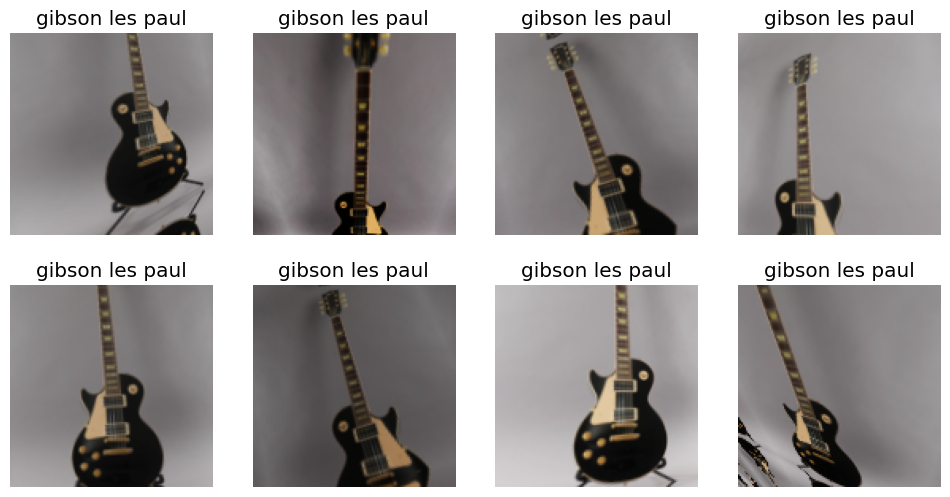

In [9]:
guitars = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fastbook.parent_label,
    item_tfms=fastbook.Resize(128),
    batch_tfms=fastbook.aug_transforms(mult=2)
)
guitar_dataloaders = guitars.dataloaders(data_path)
guitar_dataloaders.train.show_batch(max_n=8, nrows=2, unique=True)

Expand the resolution and fine-tune a resnet18 model.

In [10]:
guitars = guitars.new(
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())
guitar_dataloaders = guitars.dataloaders(data_path)
learner = fastbook.vision_learner(guitar_dataloaders, fastbook.resnet18, metrics=fastbook.error_rate)
learner.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/tom/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.358669,0.971192,0.379310,01:04


epoch,train_loss,valid_loss,error_rate,time
0,1.092296,0.621888,0.181034,01:23
1,0.819210,0.524963,0.129310,01:24
2,0.642040,0.454922,0.086207,01:20
3,0.525746,0.421668,0.077586,01:22


Now I can take a look at the confusion matrix to see where I am possibly hitting errors.

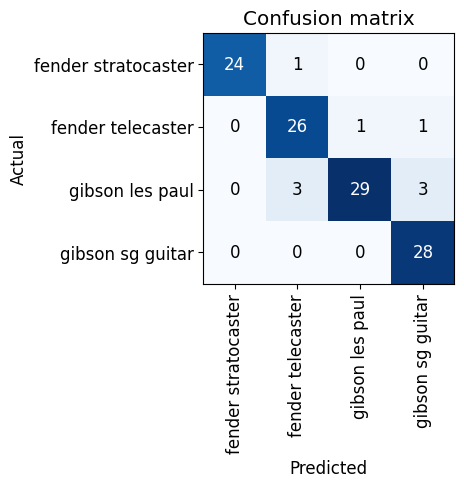

In [11]:
interpretation = fastbook.ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix()

Let's take a look at what predictions were the most off vs their actual, based on the highest loss.

/home/tom/.cache/pypoetry/virtualenvs/fastai-coursework-0G3zp8jV-py3.10/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


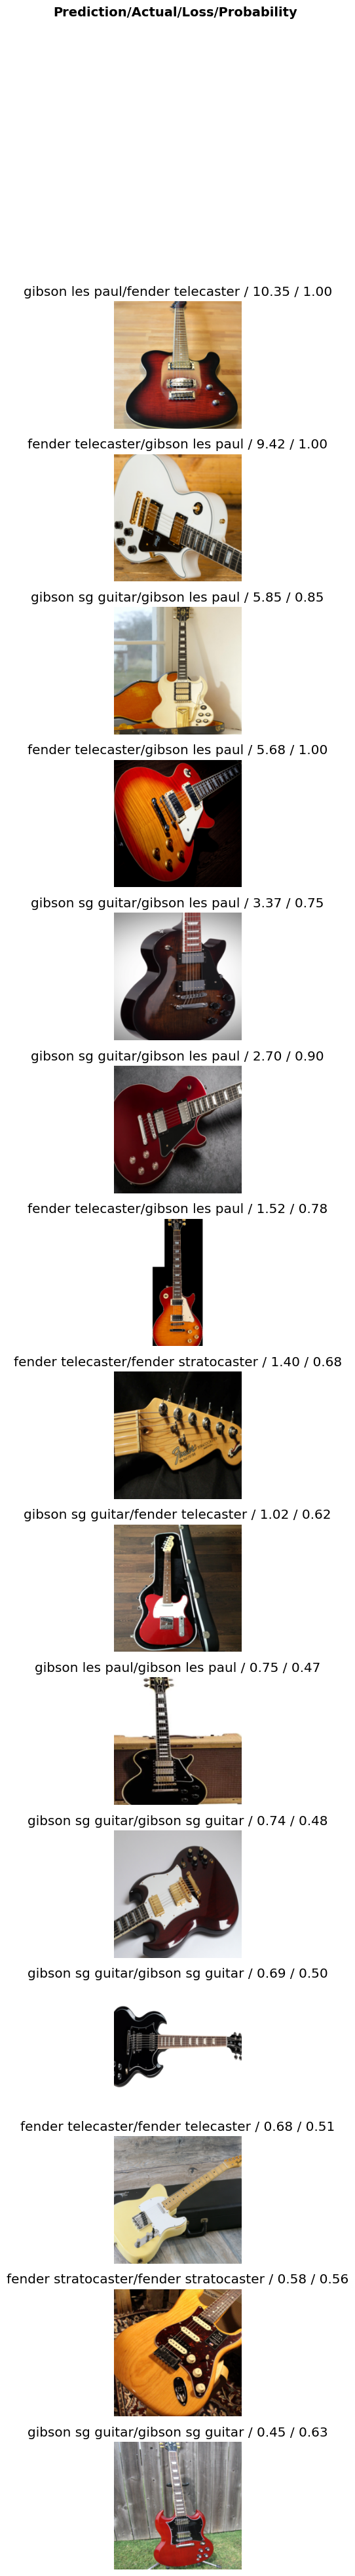

In [12]:
interpretation.plot_top_losses(15, nrows=15)

There are some things to clean up. You can use fastai's ImageClassifierCleaner but my experience was a little buggy and looking at thumbnails was quicker for me.

In [ ]:
# #hide_output
# cleaner = fastai.vision.widgets.ImageClassifierCleaner(learner)
# cleaner

In [13]:
guitars = guitars.new(
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())
guitar_dataloaders = guitars.dataloaders(data_path)
learner = fastbook.vision_learner(guitar_dataloaders, fastbook.resnet18, metrics=fastbook.error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.102176,1.283893,0.421053,00:53


epoch,train_loss,valid_loss,error_rate,time
0,1.109674,0.475415,0.189474,01:09
1,0.931216,0.210612,0.073684,01:12
2,0.735691,0.160910,0.073684,01:09
3,0.619472,0.147526,0.063158,01:09


Getting more accurate results now that the data is cleaned up.

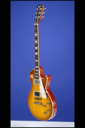

In [17]:
lespaul = fastbook.Image.open(notebook_path / 'test' / 'lespaul.jpg')
lespaul.to_thumb(256, 256)

In [24]:
print(learner.predict(notebook_path / 'test' / 'lespaul.jpg'))

('gibson les paul', tensor(2), tensor([2.1062e-06, 3.7680e-05, 9.9996e-01, 1.3638e-06]))


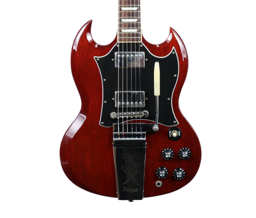

In [25]:
sg = fastbook.Image.open(notebook_path / 'test' / 'sg.jpg')
sg.to_thumb(256, 256)

In [26]:
print(learner.predict(notebook_path / 'test' / 'sg.jpg'))

('gibson sg guitar', tensor(3), tensor([1.4016e-04, 3.0350e-06, 9.3074e-08, 9.9986e-01]))


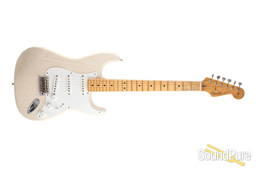

In [27]:
strat = fastbook.Image.open(notebook_path / 'test' / 'strat.jpg')
strat.to_thumb(256, 256)

In [28]:
learner.predict(notebook_path / 'test' / 'strat.jpg')

('fender telecaster',
 tensor(1),
 tensor([6.1881e-02, 8.6153e-01, 7.5101e-04, 7.5834e-02]))

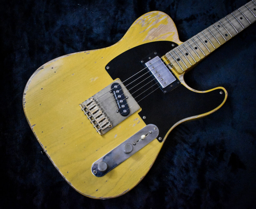

In [29]:
tele = fastbook.Image.open(notebook_path / 'test' / 'tele.jpg')
tele.to_thumb(256, 256)

In [30]:
learner.predict(notebook_path / 'test' / 'tele.jpg')

/home/tom/.cache/pypoetry/virtualenvs/fastai-coursework-0G3zp8jV-py3.10/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('fender telecaster',
 tensor(1),
 tensor([1.0416e-03, 9.9784e-01, 9.2796e-04, 1.8998e-04]))

It's performing pretty well so time to export the model to a pickle file.

In [31]:
learner.export()

In [32]:
!ls

app.py	data  export.pkl  test	train_model.ipynb
